### LATENT DIRICHLET ALLOCATION

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS

from collections import Counter

# nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from tokenize import tokenize

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')


**Load data**

In [3]:
d = pd.read_csv('Y:/DQSS/Death/MBG/py/capstone2/data/cods_GCrecords_ICD10tokens_1619.csv')

**Tokenize and clean text**

In [9]:
## call stored object 'gc_all' created in 2_PrepData_ICD10.ipynb.  Will only work if you run that notebook first.
%store -r gc_all  
gc_all = gc_all + ['J969', 'J960', 'J961']
gc_all[-1]

'J961'

In [10]:
def preproc(data):
    cod_tokens = []
    for cod in data:
        cod_words = word_tokenize(cod)
        cod_nostop = [w for w in cod_words if w not in gc_all]
        cod_tokens.append(cod_nostop)
    return cod_tokens

In [11]:
d['clean_mc'] = preproc(d['AllMC'])

In [13]:
# add 'respiratory failure' codes to the list of stopwords
respfailcodes = ['J960','J961','J969']
gc_all.extend(respfailcodes)

def preproc2(data):
    cod_tokens = []
    for cod in data:
        cod_words = word_tokenize(cod)
        cod_nostop = [w for w in cod_words if w not in gc_all]
        cod_short = [w[0:3] for w in cod_nostop]
        cod_tokens.append(cod_short)
    return cod_tokens

In [15]:
d['short_mc'] = preproc2(d['AllMC'])

In [5]:
def make_bigrams(doc):
    bi = []
    for i in range(len(doc)-1):
        bigrm = doc[i] + "_" + doc[i+1]
        bi.append(bigrm)
    return bi   

In [6]:
d['all_bigrams'] = d['clean_mc'].apply(lambda row: make_bigrams(row))

In [4]:
d.head()

,Unnamed: 0,gc_cat,gc_cat_label,codlit,UCOD,AllMC,tobac,dody,clean_mc,short_mc
0,4,2,2-Heart failure,"SUDDEN CARDIAC DEATH, PROBABLE ARRHYTHMIA ATRI...",I509,I509 A310 F179 I120 I461 I48 J449 K922 Q600 ...,P,2017,"['A310', 'F179', 'I120', 'I48', 'J449', 'K922'...","['A31', 'F17', 'I12', 'I48', 'J44', 'K92', 'Q60']"
1,5,2,2-Heart failure,PNEUMONIA SYSTOLIC CONGESTIVE HEART FAILURE ...,I500,I500 F03 J189,N,2017,"['F03', 'J189']","['F03', 'J18']"
2,46,2,2-Heart failure,"CONGESTIVE HEART FAILURE, CAUSE NOT FORMALLY W...",I500,I500 D469 I802 J189 T828 Y831,N,2017,"['D469', 'I802', 'J189', 'Y831']","['D46', 'I80', 'J18', 'Y83']"
3,53,3,3-Ill-defined cancer,METASTATIC MALIGNANCY WITH PERITONEAL CARCINOM...,C80,C80 B182 C786 N179,U,2018,"['B182', 'C786', 'N179']","['B18', 'C78', 'N17']"
4,96,6,6-Ill-defined cardiovascular,"UNSPECIFIED NATURAL CAUSES HYPERTENSION, AT...",I10,I10 I48,N,2017,['I48'],['I48']


**CONSTRUCT DICTIONARY**

In [16]:
'''create dictionary for later use and also create bag of words - prune words that occur in 5 or fewer records
or more than 50% of records'''

dictionary_uni = gensim.corpora.Dictionary(d.clean_mc)
dictionary_uni.filter_extremes(no_below=5, no_above=0.5)

dictionary_uni_short = gensim.corpora.Dictionary(d.short_mc)
dictionary_uni_short.filter_extremes(no_below=5, no_above=0.5)

dictionary_bi = gensim.corpora.Dictionary(d.all_bigrams)
dictionary_bi.filter_extremes(no_below=5, no_above=0.5)

In [12]:
len(dictionary_uni),len(dictionary_bi)

(340, 337)

**CONSTRUCT BAG OF WORDS**

In [17]:
'''bag of words - for each document there is now a dictionary.  
Word counts can be figured out using these with BOW.'''

bow_corpus_uni = [dictionary_uni.doc2bow(doc) for doc in d.clean_mc]
bow_corpus_uni_short = [dictionary_uni_short.doc2bow(doc) for doc in d.short_mc]
bow_corpus_bi = [dictionary_bi.doc2bow(doc) for doc in d.all_bigrams]

**TF-IDF corpus**

In [18]:
from gensim import corpora, models

tfidf_uni = models.TfidfModel(bow_corpus_uni)
corpus_uni = tfidf_uni[bow_corpus_uni]

tfidf_uni_short = models.TfidfModel(bow_corpus_uni_short)
corpus_uni_short = tfidf_uni_short[bow_corpus_uni_short]


tfidf_bi = models.TfidfModel(bow_corpus_bi)
corpus_bi = tfidf_bi[bow_corpus_bi]

**LDA with TF-IDF corpus** created with records that have garbage ICD-10 codes for the underlying cause.

**WITH UNIGRAMS**

In [15]:
ldamodel_all_uni = gensim.models.LdaMulticore(corpus_uni,
                                              id2word=dictionary_uni,
                                              num_topics=6,
                                              passes=50,
                                              alpha = 0.5,
                                              eta = 0.1,
                                              workers=4
                                             )

In [16]:
for idx, topic in ldamodel_all_uni.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx,topic))

Topic: 0 
Words: 0.190*"I48" + 0.164*"J189" + 0.139*"F03" + 0.061*"G931" + 0.049*"N390" + 0.038*"A499" + 0.031*"E668" + 0.028*"J80" + 0.025*"D649" + 0.022*"W80"
Topic: 1 
Words: 0.097*"E119" + 0.070*"N185" + 0.069*"C780" + 0.068*"I251" + 0.057*"C795" + 0.053*"I739" + 0.053*"C798" + 0.036*"E039" + 0.034*"I120" + 0.034*"C786"
Topic: 2 
Words: 0.406*"F179" + 0.130*"N179" + 0.079*"N189" + 0.073*"G309" + 0.062*"C787" + 0.049*"I64" + 0.032*"I458" + 0.020*"I802" + 0.016*"I710" + 0.014*"C509"
Topic: 3 
Words: 0.133*"F019" + 0.087*"N288" + 0.071*"A490" + 0.055*"G934" + 0.051*"E142" + 0.036*"I694" + 0.035*"G20" + 0.034*"I350" + 0.030*"A491" + 0.028*"E43"
Topic: 4 
Words: 0.208*"J449" + 0.090*"N19" + 0.068*"J961" + 0.052*"J90" + 0.040*"K729" + 0.036*"E46" + 0.036*"I959" + 0.023*"I272" + 0.020*"C349" + 0.020*"I472"
Topic: 5 
Words: 0.124*"E149" + 0.100*"E785" + 0.076*"J690" + 0.051*"E669" + 0.048*"K922" + 0.041*"G473" + 0.039*"K746" + 0.038*"I219" + 0.036*"J81" + 0.036*"A498"


**Evaluate LDA model using the full TF-IDF corpus with unigrams**

In [ ]:
coherence_ldamodel_all_uni = CoherenceModel(model = ldamodel_all_uni, 
                                      texts = d.clean_mc, 
                                      dictionary = dictionary_uni, 
                                      coherence = 'c_v')

coherence_ldamodel_all_uni = coherence_ldamodel_all_uni.get_coherence()

In [19]:
print("Coherence score for LDA model for all records with unigrams and 15 passes: ", coherence_ldamodel_all_uni)

Coherence score for LDA model for all records with unigrams and 15 passes:  0.5284081502957344


In [20]:
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis
pyLDAvis.enable_notebook()
ldamodel_all_uni_vis = pyLDAvis.gensim.prepare(ldamodel_all_uni, corpus_uni, dictionary_uni)
ldamodel_all_uni_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.372242 -0.000560       1        1  17.492819
0      0.215282  0.160751       2        1  17.491095
5      0.110600 -0.365154       3        1  16.729818
1      0.012320 -0.104756       4        1  16.433979
4     -0.104359  0.148309       5        1  16.224579
3      0.138399  0.161410       6        1  15.627715, topic_info=     Term        Freq       Total Category  logprob  loglift
0    F179  751.000000  751.000000  Default  30.0000  30.0000
3    J449  353.000000  353.000000  Default  29.0000  29.0000
2     I48  357.000000  357.000000  Default  28.0000  28.0000
6    J189  301.000000  301.000000  Default  27.0000  27.0000
5     F03  254.000000  254.000000  Default  26.0000  26.0000
..    ...         ...         ...      ...      ...      ...
107  M628   14.745077   15.230864   Topic6  -4.7070   1.8237
213  L089   14.228377   14.711330   Topic6  -4.7427   1.8227
220  D696   16.772696   17.356331   Topic6  -4.5782   1.8219
136  I330   13.011187   13.494090   Topic6  -4.8321   1.8197
177  I629   12.634518   13.117212   Topic6  -4.8615   1.8186

[216 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
87        4  0.946811  A047
242       6  0.969904  A099
37        6  0.994461  A490
80        6  0.996122  A491
14        3  0.997062  A498
...     ...       ...   ...
172       3  0.935748  Y442
310       1  0.980553  Y830
9         2  0.979690  Y831
201       1  0.904581  Y836
84        1  0.965910  Y839

[208 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 6, 2, 5, 4])

**WITH UNIGRAMS AND SHORT ICD-10 CODES**

In [19]:
ldamodel_all_uni_short = gensim.models.LdaMulticore(corpus_uni_short,
                                              id2word=dictionary_uni_short,
                                              num_topics=6,
                                              passes=50,
                                              alpha = 0.5,
                                              eta = 0.1,
                                              workers=4
                                             )

In [20]:
for idx, topic in ldamodel_all_uni_short.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx,topic))

Topic: 0 
Words: 0.211*"E14" + 0.121*"G30" + 0.086*"I71" + 0.064*"K92" + 0.047*"J81" + 0.045*"I35" + 0.043*"I95" + 0.037*"K56" + 0.028*"I47" + 0.027*"X59"
Topic: 1 
Words: 0.210*"C78" + 0.192*"F03" + 0.160*"C79" + 0.068*"N39" + 0.057*"J90" + 0.034*"Y83" + 0.032*"I80" + 0.028*"K70" + 0.027*"J84" + 0.027*"E43"
Topic: 2 
Words: 0.210*"J18" + 0.121*"E11" + 0.047*"G47" + 0.044*"K74" + 0.038*"J98" + 0.036*"E03" + 0.036*"E46" + 0.036*"I12" + 0.034*"I69" + 0.030*"I42"
Topic: 3 
Words: 0.165*"A49" + 0.100*"N28" + 0.097*"N19" + 0.091*"J69" + 0.072*"I64" + 0.063*"I21" + 0.047*"D64" + 0.035*"I27" + 0.031*"W80" + 0.027*"G31"
Topic: 4 
Words: 0.165*"N18" + 0.162*"N17" + 0.120*"G93" + 0.117*"E78" + 0.084*"E66" + 0.049*"I73" + 0.044*"I45" + 0.028*"E88" + 0.021*"K55" + 0.017*"J45"
Topic: 5 
Words: 0.357*"F17" + 0.157*"I48" + 0.149*"J44" + 0.078*"F01" + 0.054*"I25" + 0.035*"K72" + 0.032*"F10" + 0.023*"J80" + 0.018*"K76" + 0.017*"I63"


In [21]:
coherence_ldamodel_all_uni_short = CoherenceModel(model = ldamodel_all_uni_short, 
                                      texts = d.short_mc, 
                                      dictionary = dictionary_uni_short, 
                                      coherence = 'c_v')

coherence_ldamodel_all_uni_short = coherence_ldamodel_all_uni_short.get_coherence()

print("Coherence score for LDA model for all records with unigrams and 15 passes: ", coherence_ldamodel_all_uni_short)


Coherence score for LDA model for all records with unigrams and 15 passes:  0.5288361470944306


In [22]:
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis
pyLDAvis.enable_notebook()
ldamodel_all_uni_short_vis = pyLDAvis.gensim.prepare(ldamodel_all_uni_short, corpus_uni_short, dictionary_uni_short)
ldamodel_all_uni_short_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.357330  0.141804       1        1  19.018456
4     -0.223827  0.182259       2        1  16.945387
2     -0.003122  0.014662       3        1  16.585974
3     -0.205437 -0.109560       4        1  15.971687
1      0.083542 -0.372526       5        1  15.936881
0     -0.008486  0.143362       6        1  15.541623, topic_info=    Term        Freq       Total Category  logprob  loglift
0    F17  715.000000  715.000000  Default  30.0000  30.0000
6    J18  365.000000  365.000000  Default  29.0000  29.0000
11   C78  351.000000  351.000000  Default  28.0000  28.0000
26   E14  343.000000  343.000000  Default  27.0000  27.0000
5    F03  320.000000  320.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
164  F43   11.154322   11.648463   Topic6  -4.9816   1.8183
140  K26   10.554445   11.048515   Topic6  -5.0369   1.8159
42   K31   10.325922   10.819951   Topic6  -5.0588   1.8149
98   F91   10.125004   10.619622   Topic6  -5.0785   1.8140
207  G35    8.414120    8.908437   Topic6  -5.2636   1.8046

[214 rows x 6 columns], token_table=      Topic      Freq Term
term                      
75        6  0.963891  A04
177       3  0.983370  A09
15        4  0.997680  A49
10        1  0.984432  B18
222       1  0.971040  B34
...     ...       ...  ...
133       2  0.956498  Y43
135       6  0.960731  Y44
9         5  0.992658  Y83
103       2  0.984330  Y84
125       1  0.801029  Y86

[205 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 3, 4, 2, 1])

**WITH BIGRAMS**

In [21]:
ldamodel_all_bi = gensim.models.LdaMulticore(corpus_bi,
                                              id2word=dictionary_bi,
                                              num_topics=6,
                                              passes=30,
                                              alpha = 0.5,
                                              eta = 0.1,
                                              workers=4
                                             )

for idx, topic in ldamodel_all_bi.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx,topic))


Topic: 0 
Words: 0.089*"N179_N189" + 0.086*"E785_F179" + 0.048*"I48_I64" + 0.048*"I251_I48" + 0.037*"F03_J189" + 0.035*"E149_E669" + 0.034*"J189_J90" + 0.034*"G309_I48" + 0.030*"F179_J439" + 0.027*"F179_I458"
Topic: 1 
Words: 0.201*"F179_J449" + 0.054*"F179_J189" + 0.038*"F03_F179" + 0.035*"E149_F179" + 0.030*"F179_I739" + 0.030*"E785_F019" + 0.027*"F019_F179" + 0.026*"F179_G473" + 0.026*"J449_J961" + 0.023*"F102_F179"
Topic: 2 
Words: 0.063*"J189_N179" + 0.062*"F03_I48" + 0.039*"C780_C798" + 0.034*"C798_F179" + 0.031*"C349_F179" + 0.031*"C795_C798" + 0.030*"I739_J449" + 0.027*"E785_F03" + 0.024*"J449_N179" + 0.024*"E669_E785"
Topic: 3 
Words: 0.053*"E149_E785" + 0.052*"F179_I251" + 0.043*"C787_C788" + 0.039*"E119_E785" + 0.033*"E669_F179" + 0.032*"C780_C795" + 0.030*"C795_F179" + 0.029*"N179_N390" + 0.028*"C780_C793" + 0.026*"F179_J961"
Topic: 4 
Words: 0.095*"F179_I48" + 0.067*"I48_J449" + 0.050*"C787_C795" + 0.047*"I48_J189" + 0.040*"J189_J80" + 0.034*"F019_I48" + 0.025*"G931_I458" 

In [22]:
coherence_ldamodel_all_bi = CoherenceModel(model = ldamodel_all_bi, 
                                      texts = d.all_bigrams, 
                                      dictionary = dictionary_bi, 
                                      coherence = 'c_v')

coherence_ldamodel_all_bi = coherence_ldamodel_all_bi.get_coherence()

print("Coherence score for LDA model for all records with bigrams and 30 passes: ", coherence_ldamodel_all_bi)

Coherence score for LDA model for all records with bigrams and 30 passes:  0.7649449418992815


In [23]:
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis
pyLDAvis.enable_notebook()
ldamodel_all_bi_vis = pyLDAvis.gensim.prepare(ldamodel_all_bi, corpus_bi, dictionary_bi)
ldamodel_all_bi_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.394905 -0.001190       1        1  17.939417
4     -0.058313 -0.294305       2        1  17.122057
0     -0.050411  0.299938       3        1  16.427485
5     -0.106789 -0.059148       4        1  16.242809
3     -0.125496  0.068989       5        1  16.232388
2     -0.053895 -0.014283       6        1  16.035833, topic_info=          Term        Freq       Total Category  logprob  loglift
8    F179_J449  116.000000  116.000000  Default  30.0000  30.0000
101   F179_I48   52.000000   52.000000  Default  29.0000  29.0000
102  N179_N189   47.000000   47.000000  Default  28.0000  28.0000
97   E785_F179   45.000000   45.000000  Default  27.0000  27.0000
21   C780_C787   45.000000   45.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
334  C785_C786    7.029964    7.504989   Topic6  -4.2871   1.7650
156  F179_I214    6.828848    7.297842   Topic6  -4.3161   1.7639
104   F03_G934    6.907467    7.393916   Topic6  -4.3047   1.7623
222  J189_N185    6.629456    7.098155   Topic6  -4.3458   1.7620
50   F179_K729    6.284374    6.752612   Topic6  -4.3992   1.7585

[211 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
90        3  0.923748  A490_F179
163       1  0.958098  A499_F179
212       2  0.880953  B182_F179
279       6  0.973581  C349_F179
286       6  0.938832  C780_C786
...     ...       ...        ...
211       2  0.890947  N009_N189
102       3  0.972169  N179_N189
66        5  0.967021  N179_N390
49        2  0.975032  N189_N288
34        4  0.896813  N288_N390

[183 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 6, 4, 3])

**REPEAT LDA FOR EACH GARBAGE CODE CATEGORY INDIVIDUALLY USING UNIGRAMS** excluding categories 4, 7, 8, and 9 due to insufficient records.

**LDA FOR GARBAGE CODE CATEGORY 1: SEPTICEMIA**

In [34]:
gc1 = preproc(d.loc[d['gc_cat']==1, 'AllMC'])
id2word1= gensim.corpora.Dictionary(gc1)
id2word1.filter_extremes(no_below=20, keep_n=300)
bow_corpus_gc1 = [id2word1.doc2bow(doc) for doc in gc1]
tfidf_gc1 = models.TfidfModel(bow_corpus_gc1)
corpus_cat1 = tfidf_gc1[bow_corpus_gc1]
lda_cat1 = gensim.models.LdaMulticore(corpus_cat1,
                                      num_topics=6,
                                      id2word=id2word1,
                                      passes=30,
                                      workers=4
                                     )


In [35]:
for idx, topic in lda_cat1.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx,topic))

Topic: 0 
Words: 0.306*"J189" + 0.090*"N19" + 0.087*"N189" + 0.083*"G309" + 0.080*"E119" + 0.072*"G934" + 0.055*"E889" + 0.046*"I429" + 0.045*"N179" + 0.041*"I48"
Topic: 1 
Words: 0.261*"F179" + 0.206*"N390" + 0.075*"G20" + 0.074*"I251" + 0.059*"D65" + 0.059*"I350" + 0.057*"J189" + 0.053*"E46" + 0.043*"F03" + 0.035*"I48"
Topic: 2 
Words: 0.169*"A498" + 0.149*"J690" + 0.134*"J80" + 0.103*"I219" + 0.074*"E142" + 0.064*"I214" + 0.054*"N179" + 0.043*"J189" + 0.042*"J81" + 0.040*"I694"
Topic: 3 
Words: 0.159*"F03" + 0.132*"J449" + 0.120*"A491" + 0.110*"E149" + 0.103*"N288" + 0.069*"G931" + 0.062*"I959" + 0.055*"E43" + 0.054*"F179" + 0.044*"I48"
Topic: 4 
Words: 0.254*"A490" + 0.233*"N179" + 0.099*"K746" + 0.091*"I48" + 0.051*"D649" + 0.047*"J961" + 0.042*"K729" + 0.039*"J152" + 0.039*"K703" + 0.038*"E112"
Topic: 5 
Words: 0.261*"A499" + 0.127*"N185" + 0.092*"K922" + 0.089*"J440" + 0.086*"I458" + 0.073*"I64" + 0.068*"I739" + 0.063*"F179" + 0.045*"W80" + 0.029*"I251"


In [36]:
coherence_lda_cat1 = CoherenceModel(model = lda_cat1, 
                                      texts = gc1, 
                                      dictionary = id2word1, 
                                      coherence = 'c_v')

coherence_lda_cat1 = coherence_lda_cat1 .get_coherence()
print("Coherence score for LDA model for GC category 1 ('Septicemia') - 12 topics, 30 passes: ", coherence_lda_cat1)

Coherence score for LDA model for GC category 1 ('Septicemia') - 12 topics, 30 passes:  0.29043365265696147


In [37]:
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis
pyLDAvis.enable_notebook()
LDA_cat1_vis = pyLDAvis.gensim.prepare(lda_cat1, corpus_cat1, id2word1)
LDA_cat1_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.197823  0.128258       1        1  18.796581
2      0.220334 -0.171213       2        1  17.130346
4      0.062825 -0.162152       3        1  17.094776
3     -0.091775  0.164759       4        1  16.833191
5     -0.324679 -0.154768       5        1  15.291434
1     -0.064528  0.195115       6        1  14.853674, topic_info=    Term        Freq       Total Category  logprob  loglift
7   A490   97.000000   97.000000  Default  30.0000  30.0000
31  A499   89.000000   89.000000  Default  29.0000  29.0000
16  J189  163.000000  163.000000  Default  28.0000  28.0000
19  N390   68.000000   68.000000  Default  27.0000  27.0000
17  F179  131.000000  131.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
3   G309    0.182397   35.443737   Topic6  -7.4978  -3.3626
14   J80    0.182314   51.825386   Topic6  -7.4982  -3.7430
31  A499    0.182262   89.407196   Topic6  -7.4985  -4.2886
0   A498    0.181934   64.983467   Topic6  -7.5003  -3.9713
30  K746    0.181816   38.436619   Topic6  -7.5009  -3.4468

[272 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
7         3  0.987303  A490
23        4  0.989502  A491
0         2  0.984866  A498
31        5  0.995446  A499
5         3  0.938327  D649
...     ...       ...   ...
20        2  0.141621  N288
20        3  0.141621  N288
20        4  0.597954  N288
19        6  0.991360  N390
35        5  0.942361   W80

[79 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 4, 6, 2])

**LDA FOR GARBAGE CODE CATEGORY 2: HEART FAILURE**

In [43]:
gc2 = preproc(d.loc[d['gc_cat']==2, 'AllMC'])
id2word2= gensim.corpora.Dictionary(gc2)
id2word2.filter_extremes(no_below=20, keep_n=300)
bow_corpus_gc2 = [id2word2.doc2bow(doc) for doc in gc2]
tfidf_gc2 = models.TfidfModel(bow_corpus_gc2)
corpus_cat2 = tfidf_gc2[bow_corpus_gc2]
lda_cat2 = gensim.models.LdaMulticore(corpus_cat2,
                                      num_topics=12,
                                      id2word=id2word2,
                                      passes=30,
                                      workers=4,
                                      alpha = 0.5,
                                      eta=0.2
                                     )

In [44]:
for idx, topic in lda_cat2.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx,topic))

Topic: 0 
Words: 0.754*"F179" + 0.222*"J961" + 0.003*"J449" + 0.001*"F03" + 0.001*"N185" + 0.001*"N19" + 0.001*"J90" + 0.001*"I48" + 0.001*"J690" + 0.001*"N179"
Topic: 1 
Words: 0.514*"N189" + 0.238*"N288" + 0.109*"E785" + 0.105*"G931" + 0.003*"F179" + 0.002*"F03" + 0.002*"J90" + 0.001*"J961" + 0.001*"N179" + 0.001*"J449"
Topic: 2 
Words: 0.495*"N19" + 0.229*"I64" + 0.220*"I120" + 0.006*"F179" + 0.004*"J449" + 0.002*"N189" + 0.002*"J961" + 0.002*"N185" + 0.002*"E119" + 0.002*"E785"
Topic: 3 
Words: 0.680*"I48" + 0.247*"J90" + 0.018*"F179" + 0.004*"J961" + 0.003*"J449" + 0.002*"N189" + 0.002*"F03" + 0.002*"J690" + 0.002*"N19" + 0.002*"N390"
Topic: 4 
Words: 0.930*"J189" + 0.010*"F179" + 0.007*"J449" + 0.002*"F03" + 0.002*"N390" + 0.002*"N179" + 0.002*"J961" + 0.002*"N189" + 0.002*"J90" + 0.002*"E142"
Topic: 5 
Words: 0.860*"N179" + 0.046*"F179" + 0.017*"N189" + 0.009*"F03" + 0.008*"J961" + 0.003*"J189" + 0.003*"J90" + 0.003*"J449" + 0.003*"E119" + 0.002*"I48"
Topic: 6 
Words: 0.477*"G30

In [45]:
coherence_lda_cat2 = CoherenceModel(model = lda_cat2, 
                                      texts = gc2, 
                                      dictionary = id2word2, 
                                      coherence = 'c_v')

coherencescore_lda_cat2 = coherence_lda_cat2.get_coherence()
print("Coherence score for LDA_TF-IDF for GC category 2 ('Heart failure') with 25 topics and 30 passes: ", coherencescore_lda_cat2)

Coherence score for LDA_TF-IDF for GC category 2 ('Heart failure') with 25 topics and 30 passes:  0.4487385660051931


In [46]:
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis
pyLDAvis.enable_notebook()
LDA_cat2_vis = pyLDAvis.gensim.prepare(lda_cat2, corpus_cat2, id2word2)
LDA_cat2_vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.209883 -0.204993       1        1  9.732145
11     0.144912  0.156587       2        1  8.972372
1     -0.196571 -0.172070       3        1  8.850497
8     -0.155733  0.149460       4        1  8.742832
7     -0.152840 -0.050859       5        1  8.467744
2     -0.136780  0.106568       6        1  8.155392
3      0.153428  0.113198       7        1  8.148548
4     -0.101863  0.099138       8        1  7.997599
9     -0.051924  0.007820       9        1  7.887207
5      0.012174 -0.233192      10        1  7.857893
10     0.209896  0.074125      11        1  7.614391
6      0.065417 -0.045781      12        1  7.573382, topic_info=    Term        Freq       Total Category  logprob  loglift
6   J189  128.000000  128.000000  Default  30.0000  30.0000
21  N179  117.000000  117.000000  Default  29.0000  29.0000
2    I48   96.000000   96.000000  Default  28.0000  28.0000
0   F179  150.000000  150.000000  Default  27.0000  27.0000
5    F03   99.000000   99.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
25   N19    0.374237   70.755852  Topic12  -5.8335  -2.6616
10  N189    0.394496   82.338448  Topic12  -5.7808  -2.7605
2    I48    0.366506   96.224861  Topic12  -5.8544  -2.9899
21  N179    0.430866  117.513405  Topic12  -5.6926  -3.0280
6   J189    0.367243  128.578003  Topic12  -5.8524  -3.2777

[414 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
28        4  0.881073  E112
13        2  0.919232  E119
13       11  0.028726  E119
17       12  0.958131  E142
8         5  0.941672  E149
...     ...       ...   ...
10       11  0.012145  N189
25        6  0.961051   N19
20        3  0.945417  N288
26        4  0.828277  N390
26       11  0.055218  N390

[62 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 12, 2, 9, 8, 3, 4, 5, 10, 6, 11, 7])

**LDA FOR GARBAGE CODE CATEGORY 3: Ill-DEFINED CANCER**

In [48]:
processed3 = preproc(d.loc[d['gc_cat']==3, 'AllMC'])
id2word3= gensim.corpora.Dictionary(processed3)
id2word3.filter_extremes(no_below=15, no_above=0.7, keep_n=100000)
bow_corpus3 = [id2word3.doc2bow(doc) for doc in processed3]
tfidf_gc3 = models.TfidfModel(bow_corpus3)
corpus_tfidf3 = tfidf_gc3[bow_corpus3]
lda_tfidf3 = gensim.models.LdaMulticore(corpus_tfidf3,
                                       num_topics=5,
                                       id2word=id2word3,
                                       passes=30,
                                       workers=4)

In [49]:
for idx, topic in lda_tfidf3.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx,topic))

Topic: 0 
Words: 0.409*"F179" + 0.163*"C798" + 0.094*"N179" + 0.084*"C780" + 0.079*"K729" + 0.063*"E46" + 0.044*"E43" + 0.031*"K720" + 0.016*"J984" + 0.003*"C787"
Topic: 1 
Words: 0.198*"J449" + 0.083*"D649" + 0.075*"N189" + 0.071*"G309" + 0.065*"F179" + 0.062*"I802" + 0.061*"I64" + 0.056*"N390" + 0.055*"E785" + 0.046*"C791"
Topic: 2 
Words: 0.229*"C787" + 0.175*"C793" + 0.086*"J90" + 0.069*"C780" + 0.068*"K566" + 0.068*"N19" + 0.055*"C782" + 0.054*"I251" + 0.053*"N288" + 0.035*"G934"
Topic: 3 
Words: 0.148*"C786" + 0.141*"I48" + 0.106*"F03" + 0.091*"E149" + 0.091*"E119" + 0.090*"C788" + 0.081*"K922" + 0.067*"E835" + 0.053*"C785" + 0.043*"C787"
Topic: 4 
Words: 0.313*"C795" + 0.189*"J189" + 0.093*"C780" + 0.079*"C787" + 0.070*"J690" + 0.064*"C779" + 0.058*"J961" + 0.056*"F179" + 0.050*"N185" + 0.001*"I48"


In [50]:
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis
pyLDAvis.enable_notebook()
LDA_tfidf3_vis = pyLDAvis.gensim.prepare(lda_tfidf3, corpus_tfidf3, id2word3)
LDA_tfidf3_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.297208 -0.021866       1        1  23.060837
2     -0.154218  0.189455       2        1  20.034739
3     -0.290645 -0.083324       3        1  19.698019
1      0.039932 -0.303518       4        1  19.580992
4      0.107724  0.219252       5        1  17.625410, topic_info=    Term        Freq       Total Category  logprob  loglift
4   C795  105.000000  105.000000  Default  30.0000  30.0000
5   F179  223.000000  223.000000  Default  29.0000  29.0000
13  J449   74.000000   74.000000  Default  28.0000  28.0000
19  J189   64.000000   64.000000  Default  27.0000  27.0000
37  C793   67.000000   67.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
14  E119    0.232007   38.743038   Topic5  -7.2759  -3.3821
23  K729    0.231765   35.473831   Topic5  -7.2770  -3.2950
28  E149    0.231740   34.891869   Topic5  -7.2771  -3.2786
20   J90    0.231689   33.439919   Topic5  -7.2773  -3.2363
43  K566    0.231656   29.055548   Topic5  -7.2775  -3.0959

[233 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         4  0.944565  B182
25        5  0.983926  C779
8         1  0.345269  C780
8         2  0.242621  C780
8         3  0.074653  C780
...     ...       ...   ...
34        4  0.975083  N189
32        2  0.979761   N19
6         2  0.953450  N288
17        4  0.968771  N390
44        4  0.942075   W80

[66 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2, 5])

In [53]:
coherence_lda_tfidf3 = CoherenceModel(model = lda_tfidf3, 
                                      texts = processed3, 
                                      dictionary = id2word3, 
                                      coherence = 'c_v')

coherence_lda_tfidf3 = coherence_lda_tfidf3.get_coherence()
print("Coherence score for LDA_TF-IDF for GC category 3 ('Ill defined cancer') with 25 topics and 30 passes: ", coherence_lda_tfidf3)

Coherence score for LDA_TF-IDF for GC category 3 ('Ill defined cancer') with 25 topics and 30 passes:  0.32195187467661446


**FINDING IDEAL NUMBER OF TOPICS - ALL CATEGORIES TOGETHER**

In [54]:
#define function to compute a series of coherence scores based on using different numbers of topics

def compute_coherence(dictionary,texts, corpus, limit, start=2, step=3):
    
    '''
    parameters:
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    limit: Max number of topcs
    texts: list of texts
    output:
    model_list: list of LDA topic models
    coherence_values: coherence values corresponding to each LDA model with number of topics
    '''
    
    model_list = []
    coherence_values = []
    
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus = corpus,
                                           id2word = dictionary,
                                           num_topics = num_topics,
                                           passes = 50,
                                           workers = 4)
        model_list.append(model)
        
        coherencemodel = CoherenceModel(model=model, texts = texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values
    

In [55]:
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

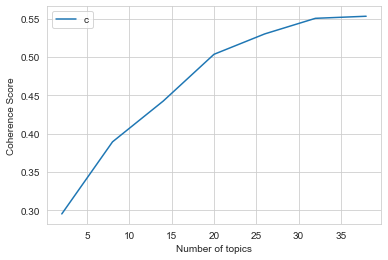

In [57]:
limit=40; start=2; step=6
x=range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc='best')
plt.show()